# Rollouts

Internal notebook to show how to get rollouts from experimental runs and from gym/imitation

In [1]:
from navground import sim

sensor = sim.load_state_estimation("""
type: Discs
number: 5
range: 5.0
max_speed: 0.12
max_radius: 0.1
""")

scenario = sim.load_scenario("""
type: Cross
agent_margin: 0.1
side: 4
target_margin: 0.1
tolerance: 0.5
groups:
  -
    type: thymio
    number: 20
    radius: 0.1
    control_period: 0.1
    speed_tolerance: 0.02
    color: gray
    kinematics:
      type: 2WDiff
      wheel_axis: 0.094
      max_speed: 0.12
    behavior:
      type: HL
      optimal_speed: 0.12
      horizon: 5.0
      tau: 0.25
      eta: 0.5
      safety_margin: 0.1
    state_estimation:
      type: Bounded
      range: 5.0
""")

In [2]:
from navground_learning.env import GymAgentConfig
import numpy as np

duration = 60.0
runs = 100
time_step =  0.1
config = GymAgentConfig()

## Using imitation

In [3]:
import time
from imitation.util.util import make_vec_env
from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper

from navground_learning.utils import get_expert

start = time.monotonic_ns()
expert = get_expert(config)
rng = np.random.default_rng(0)
venv = make_vec_env("navground",
    rng=rng,
    post_wrappers=[lambda env, _: RolloutInfoWrapper(env)],
    env_make_kwargs={
        'scenario': scenario,
        'sensor': sensor,
        'time_step': time_step,
        'max_duration': duration,
        'config': config,
    },
    parallel=False,
    n_envs=1)

mid = time.monotonic_ns()
rollouts = rollout.rollout(
    expert, venv, 
    rollout.make_sample_until(min_timesteps=None, min_episodes=runs), 
    rng=rng)

end = time.monotonic_ns()
transitions = rollout.flatten_trajectories(rollouts)
len(transitions.acts), (end - start) / 1e9 # , (mid - start) / 1e9

(60000, 9.30589725)

## Using navground experiments

In [4]:
exp  = sim.Experiment(time_step=0.1, steps=100)
exp.record_config=sim.RecordConfig(time=True)
exp.scenario = scenario

In [10]:
from navground_learning.probes import GymProbe
from functools import partial
from tqdm.notebook import tqdm

exp  = sim.Experiment(time_step=time_step, steps=int(duration / time_step))
exp.record_config=sim.RecordConfig(time=True)
exp.scenario = scenario
# should picketable for mp to work
gym_probe = partial(GymProbe, sensor=sensor, config={k: GymAgentConfig(flat=False) for k in range(1)})

exp.add_probe(gym_probe)
exp.save_directory = ''
exp.name = 'single'

In [8]:
from navground_learning.rollout import get_trajectories_from_experiment
from imitation.data import rollout

start = time.monotonic_ns()
with tqdm() as bar:
    exp.setup_tqdm(bar, number_of_runs=runs)
    exp.run(number_of_runs=runs)
end = time.monotonic_ns()
rollouts = get_trajectories_from_experiment(exp)
transitions = rollout.flatten_trajectories(list(rollouts))
len(transitions.acts), (end - start) / 1e9

0it [00:00, ?it/s]

(60000, 8.135861125)

## Comparison

- navground can store data from multiple agents
- navground can dump and then load data to/from HDF5
- navground could run an experiment over multiple processes with exp.run_mp (dump->load->join data)

Let's try with the multiprocessing

In [11]:
exp.save_directory = ''
exp.name = 'multi'
start = time.monotonic_ns()
with tqdm() as bar:
    exp.run_mp(number_of_processes=10, keep=True, number_of_runs=runs, start_index=0, bar=bar)

end = time.monotonic_ns()
rollouts = get_trajectories_from_experiment(exp)
transitions = rollout.flatten_trajectories(list(rollouts))
len(transitions.acts), (end - start) / 1e9

0it [00:00, ?it/s]

(60000, 5.74437575)

In [13]:
exp.runs[0].records

{'actions/0': <Dataset: shape (600, 2), dtype float64>,
 'observations/0/ego_target_direction': <Dataset: shape (601, 2), dtype float64>,
 'observations/0/ego_target_distance': <Dataset: shape (601, 1), dtype float64>,
 'observations/0/position': <Dataset: shape (601, 5, 2), dtype float64>,
 'observations/0/radius': <Dataset: shape (601, 5), dtype float64>,
 'observations/0/valid': <Dataset: shape (601, 5), dtype uint8>,
 'observations/0/velocity': <Dataset: shape (601, 5, 2), dtype float64>,
 'rewards/0': <Dataset: shape (600,), dtype float64>,
 'times': <Dataset: shape (600,), dtype float64>}

In [14]:
from matplotlib import pyplot as plt

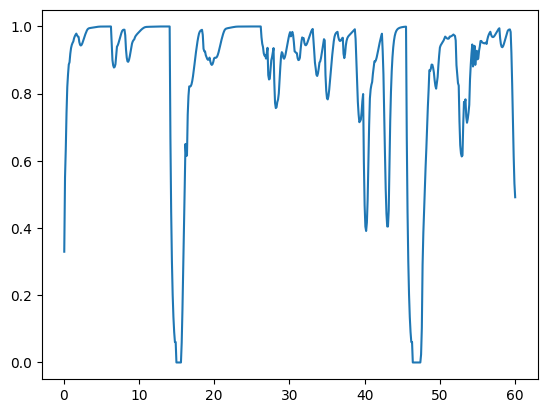

In [15]:
acts = np.asarray(exp.runs[0].get_record("actions/0"))
times = exp.runs[0].times
plt.plot(times, acts[:, 0])

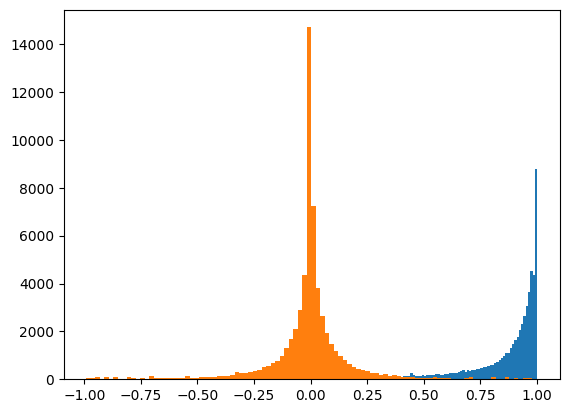

In [25]:
plt.hist(transitions.acts[:, 0], bins=100);
plt.hist(transitions.acts[:, 1], bins=100);

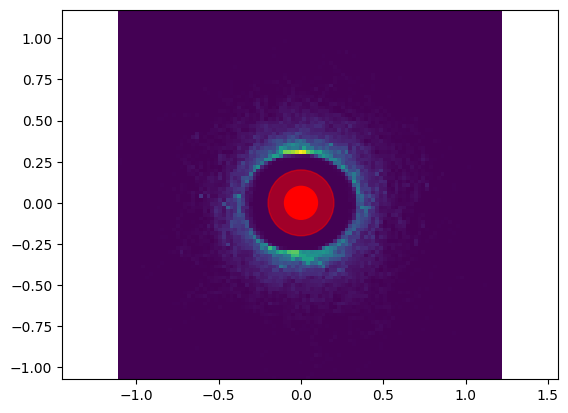

In [109]:
ps = transitions.obs.get('position')
plt.hist2d(ps[:, 0, 0], ps[:, 0, 1], bins=100);
c = plt.Circle((0, 0), 0.1, color='r')
c2 = plt.Circle((0, 0), 0.2, color='r', alpha=0.5)
plt.gca().add_patch(c)
plt.gca().add_patch(c2)
# plt.xlim(-2, 2)
# plt.ylim(-2, 2)
plt.axis('equal');

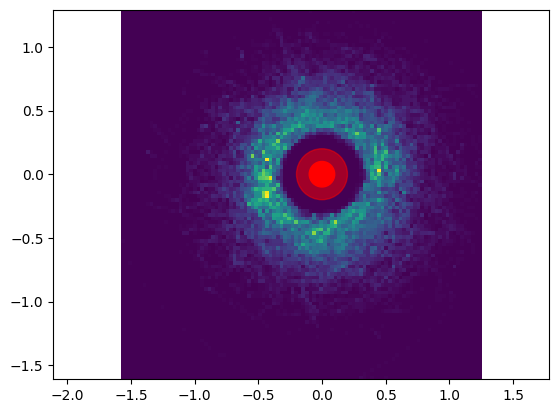

In [110]:
ps = transitions.obs.get('position')
plt.hist2d(ps[:, 1, 0], ps[:, 1, 1], bins=100);
c = plt.Circle((0, 0), 0.1, color='r')
c2 = plt.Circle((0, 0), 0.2, color='r', alpha=0.5)
plt.gca().add_patch(c)
plt.gca().add_patch(c2)
plt.axis('equal');

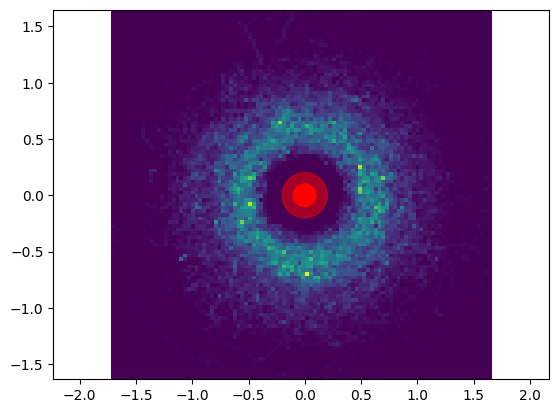

In [111]:
ps = transitions.obs.get('position')
plt.hist2d(ps[:, 2, 0], ps[:, 2, 1], bins=100);
c = plt.Circle((0, 0), 0.1, color='r')
c2 = plt.Circle((0, 0), 0.2, color='r', alpha=0.5)
plt.gca().add_patch(c)
plt.gca().add_patch(c2)
plt.axis('equal');

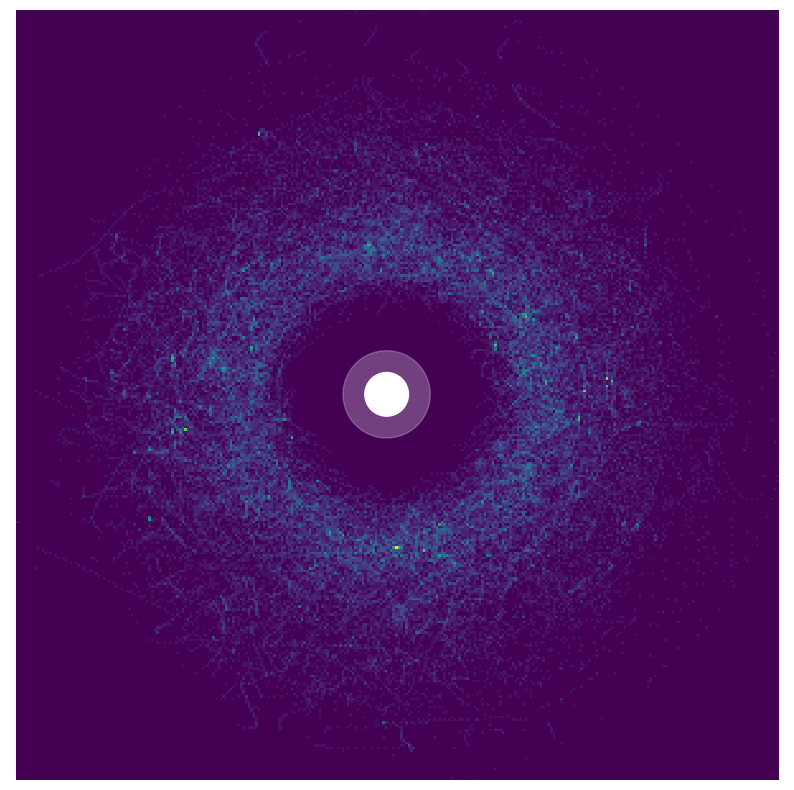

In [131]:
plt.figure(figsize=(10,10))
ps = transitions.obs.get('position')
plt.hist2d(ps[:, 3, 0], ps[:, 3, 1], bins=300);
c = plt.Circle((0, 0), 0.1, color='w')
c2 = plt.Circle((0, 0), 0.2, color='w', alpha=0.25)
plt.gca().add_patch(c)
plt.gca().add_patch(c2)
plt.axis('equal');
plt.axis('off');
plt.savefig('/Users/jerome.guzzi/Desktop/occhio.png')

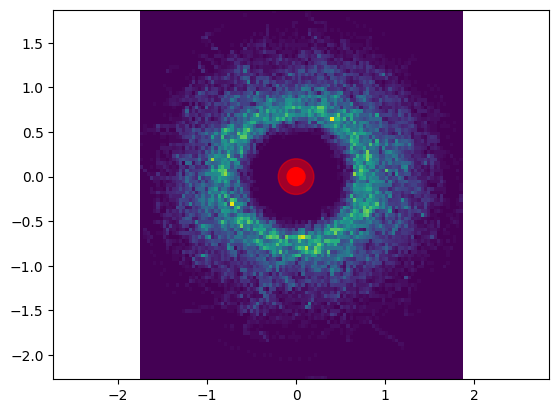

In [113]:
ps = transitions.obs.get('position')
plt.hist2d(ps[:, 4, 0], ps[:, 4, 1], bins=100);
c = plt.Circle((0, 0), 0.1, color='r')
c2 = plt.Circle((0, 0), 0.2, color='r', alpha=0.5)
plt.gca().add_patch(c)
plt.gca().add_patch(c2)
plt.axis('equal');

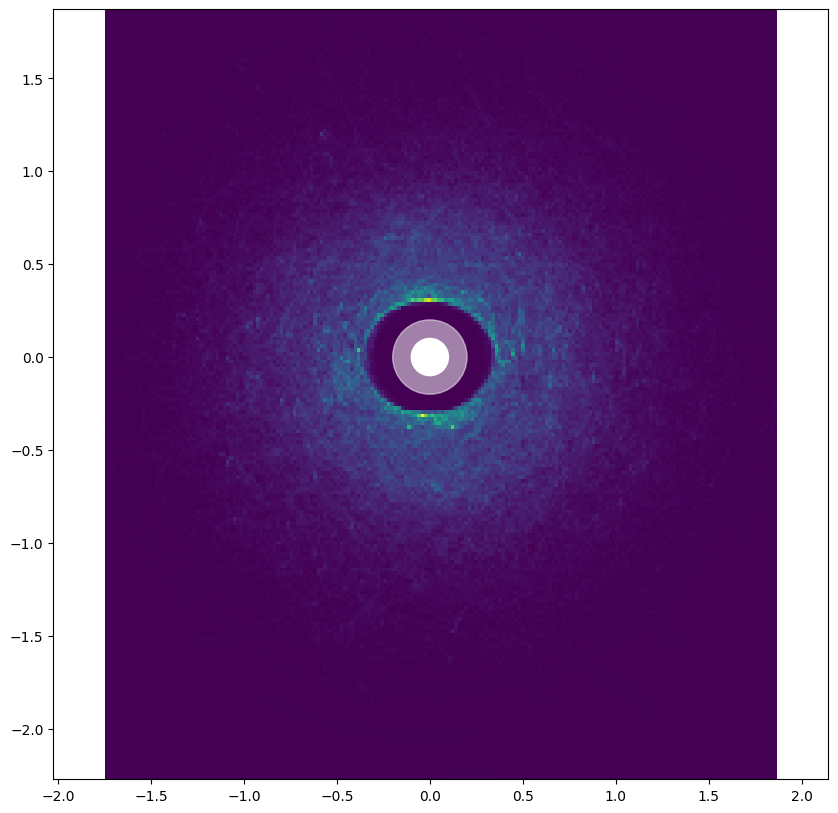

In [121]:
plt.figure(figsize=(10,10))
ps = transitions.obs.get('position')
plt.hist2d(ps[..., 0].flatten(), ps[..., 1].flatten(), bins=200);
c = plt.Circle((0, 0), 0.1, color='w')
c2 = plt.Circle((0, 0), 0.2, color='w', alpha=0.5)
plt.gca().add_patch(c)
plt.gca().add_patch(c2)
plt.axis('equal');

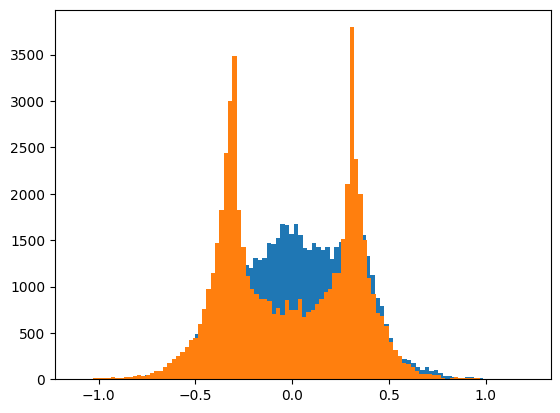

In [104]:
plt.hist(ps[:, 0, 0], bins=100);
plt.hist(ps[:, 0, 1], bins=100);

In [50]:
dist = np.linalg.norm(ps, axis=-1)

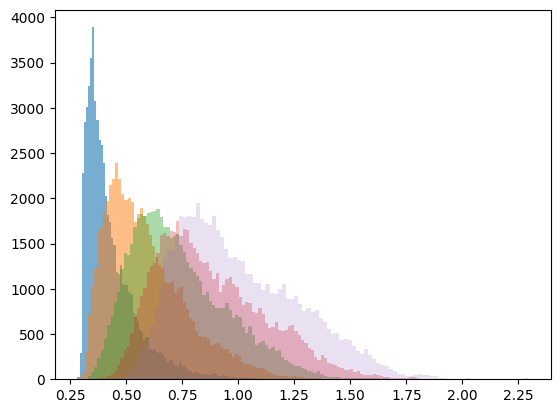

In [60]:
plt.hist(dist[:, 0], bins=100, alpha=0.6);
plt.hist(dist[:, 1], bins=100, alpha=0.5);
plt.hist(dist[:, 2], bins=100, alpha=0.4);
plt.hist(dist[:, 3], bins=100, alpha=0.3);
plt.hist(dist[:, 4], bins=100, alpha=0.2);

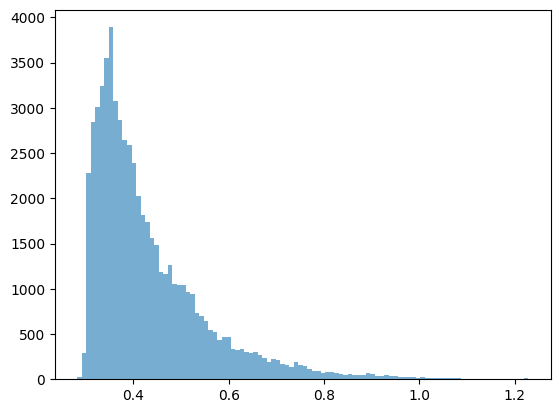

In [61]:
plt.hist(dist[:, 0], bins=100, alpha=0.6);

In [64]:
np.min(dist, axis=0)

array([0.28266742, 0.30085767, 0.32797711, 0.37188516, 0.46172007])

In [67]:
np.max(dist, axis=0)

array([1.22844569, 1.6702313 , 1.7913619 , 1.83639798, 2.29400928])

In [68]:
np.mean(dist, axis=0)

array([0.43358802, 0.59044185, 0.73869555, 0.87905538, 1.00464861])